# Exponential Smoothing in Statsmodels

In [1]:
# imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

We are going to use US monthly birth numbers for forecasting purposes. <br>

Some useful links:
* Time Series cross validation: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* Time Series decomposition: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
* Time Series tutorial - including ES: https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
* Time Series tutorial (5-part series) - everything but ES: http://dacatay.com/data-science/comprehensive-guide-time-series-analytics-visualization-prediction-python/
* Time Series overview - including ES in Python: https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
* ES in Python (3-part series): https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/
* ES intro using statsmodels: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/
* Statsmodels API: http://www.statsmodels.org/stable/tsa.html

ARIMA:
* Time Series (ARMA) overview: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#LinearModels
* ARIMA tutorial: http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
* ARIMA tutorial: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* ARIMA tutorial: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* ARIMA tutorial: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
* ARIMA tutorial with pyramid package: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
Excellent course from Microsoft with Professor Cynthia Rudin on edx.org

Prophet:
* Prophet tutorial: https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

## 1. Load and Prep Data

In [4]:
# load and prep data in one step (yoo-hoo)
df = pd.read_table('data/birth.txt')
birth = df.set_index(pd.DatetimeIndex(start='1/1/1980', end='12/31/2010', freq='M'))
birth.head()

,num_births
1980-01-31,295
1980-02-29,286
1980-03-31,300
1980-04-30,278
1980-05-31,272


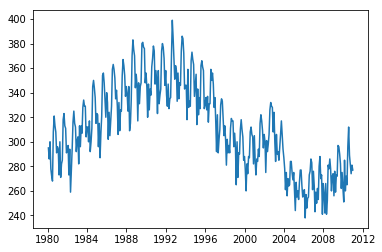

In [5]:
plt.plot(birth)

## 2. Split into Train-Test

Time series data cannot be evaluated using traditional cross validation methods. That leaves us with two options: (1) Splitting the data manually using a certain point in time as our division line between 'past' observations (the training set) and 'future' values (the testing set we can measure our forecasts against). (2) Splitting data into multiple training/testing folds using TimeSeriesSplit from the sklearn library.

Observations: 372
Training Observations: 245
Testing Observations: 127


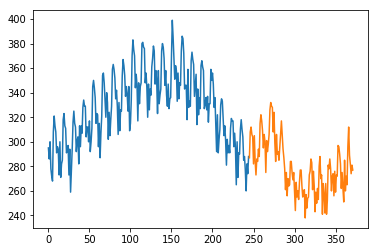

In [6]:
# splitting into training and testing sets using 66-34
X = birth.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# then plotting it using different colors
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

In [7]:
# made train_df and test_df (the latter to be used later)
train_df = birth[0:245]
train_df.head()
test_df = birth[245:372]

## 3. Forecasting Metrics

scale dependent errors (comparing forecast methods on a single data set / cannot be used to make comparisons between series that are on different scales): <br>
MD (mean deviation) $\frac{A_t-F_t}{n}$ <br>
MAD (also called MAE): $\frac{|A_t-F_t|}{n}$ <br>
MSE (mean squared error): $\frac{(A_t-F_t)^2}{n}$ <br>
RMSE (root mean squared error): $\sqrt{\frac{(A_t-F_t)^2}{n}}$ <br>
percentage errors (used to compare forecast performance between different data sets):
MPE, MAPE <br>
also scaled errors

## 4. Time Series Decomposition

can have trend, seasonal, residual <br>
$y_t = T_t+ S_t+\epsilon_t$ <br>
can be additive or multiplicative (can use different forecasting methods accordingly) <br>

statsmodel has a seasonal_decompose() function, it will show observed, can call trend, seasonal, and residual <br>
print(result.trend) <br>
print(result.seasonal) <br>
print(result.resid) <br>
print(result.observed) <br>

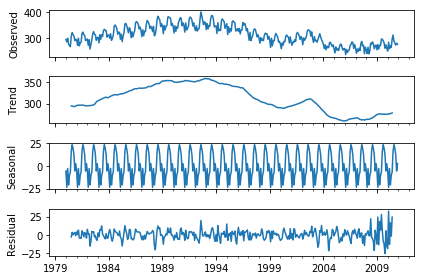

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = birth
result_a = seasonal_decompose(series, model='additive')
result_a.plot()
plt.show()

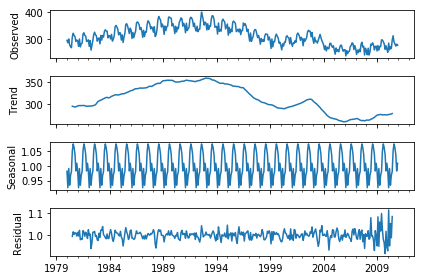

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = birth
result_m = seasonal_decompose(series, model='multiplicative')
result_m.plot()
plt.show()

Note that the various components are on different scale. The trend is roughly on the same scale as the observations, but seasonal fluctuations and residuals are on a different scale. Look at distribution of the residuals. These are very bad--shows that classical decomposition is not powerful enough to capture whatever was happening starting 2008.

## 5.2. Forecasting Methods: Exponential Smoothing

Exponential Smoothing uses trend and seasonality. It is a whole taxonomy of models. For more detail and ARIMA-ETS equivalences, see here: https://www.otexts.org/fpp/7/6

## 5.2.a. Simple Exponential Smoothing (level only)

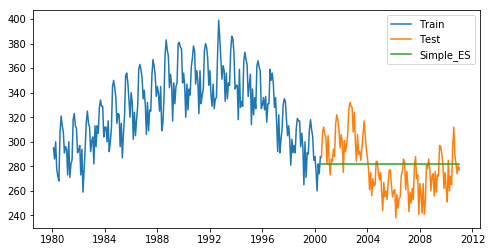

In [45]:
# what will the forecast look like? a level line 
# where it will be positioned is dependent on alpha - change alpha and see the line move up or down
from statsmodels.tsa.api import SimpleExpSmoothing

y_hat_avg = test_df.copy()
fit1 = SimpleExpSmoothing(np.asarray(train_df['num_births'])).fit(smoothing_level=0.3, optimized=False)
y_hat_avg['SES'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['SES'], label='Simple_ES')
plt.legend(loc='best')
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.SES))
print(rms)

21.447275847375384


## 5.2.b. Holt (level + trend)

Parameters:	
* endog (array-like) – Time series
* exponential (bool, optional) – Type of trend component.
* damped (bool, optional) – Should the trend component be damped.

fit() method parameters:	
* smoothing_level (float, optional) – The alpha value of the simple exponential smoothing, if the value is set then this value will be used as the value.
* smoothing_slope (float, optional) – The beta value of the holts trend method, if the value is set then this value will be used as the value.
* damping_slope (float, optional) – The phi value of the damped method, if the value is set then this value will be used as the value.
* optimized (bool, optional) – Should the values that have not been set above be optimized automatically?

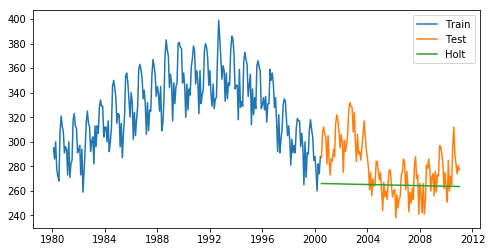

In [35]:
# what will the forecast look like? a trending line
# alpha/smoothing level will place it along the y axis
# beta/smoothing slope will give its rise/decline
from statsmodels.tsa.api import Holt

y_hat_avg = test_df.copy()
fit1 = Holt(np.asarray(train_df['num_births']), exponential=True).fit(smoothing_level=0.3, smoothing_slope=0.69)
y_hat_avg['Holt'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt))
print(rms)

25.617468832237794


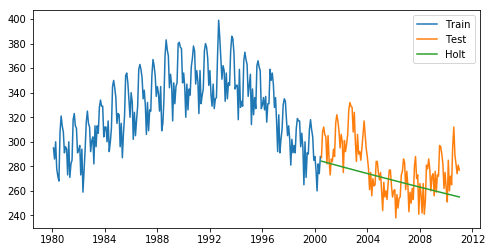

In [47]:
# now why does this do worse then just the level? 
# because we need to find the optimal parameters alpha & beta
# now try it with optimized=True
from statsmodels.tsa.api import Holt

y_hat_avg = test_df.copy()
fit1 = Holt(np.asarray(train_df['num_births']), exponential=True).fit(optimized=True)
y_hat_avg['Holt'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt))
print(rms)

21.113952253546167


## 5.2.c. Holt damped (level + trend, damped)

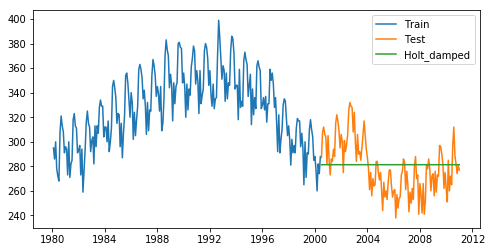

In [39]:
# again, the forecast will be a trending line
from statsmodels.tsa.api import Holt

y_hat_avg = test_df.copy()
fit1 = Holt(np.asarray(train_df['num_births']), exponential=True, damped=True).fit(smoothing_level=0.3, smoothing_slope=0.7, damping_slope=0.15)
y_hat_avg['Holt_damped'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt_damped'], label='Holt_damped')
plt.legend(loc='best')
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt_damped))
print(rms)

21.410042269655804


## 5.2.d. Double Exponential Smoothing (level + season)

Parameters:	
* endog (array-like) – Time series
* trend ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of trend component.
* damped (bool, optional) – Should the trend component be damped.
* seasonal ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of seasonal component.
* seasonal_periods (int, optional) – The number of seasons to consider for the holt winters.

fit() method Parameters:	
* smoothing_level (float, optional) – The alpha value of the simple exponential smoothing, if the value is set then this value will be used as the value.
* smoothing_slope (float, optional) – The beta value of the holts trend method, if the value is set then this value will be used as the value.
* smoothing_seasonal (float, optional) – The gamma value of the holt winters seasonal method, if the value is set then this value will be used as the value.
* damping_slope (float, optional) – The phi value of the damped method, if the value is set then this value will be used as the value.
* optimized (bool, optional) – Should the values that have not been set above be optimized automatically?
* use_boxcox ({True, False, 'log', float}, optional) – Should the boxcox tranform be applied to the data first? If ‘log’ then apply the log. If float then use lambda equal to float.
* remove_bias (bool, optional) – Should the bias be removed from the forecast values and fitted values before being returned? Does this by enforcing average residuals equal to zero.
* use_basinhopping (bool, optional) – Should the optimser try harder using basinhopping to find optimal values?

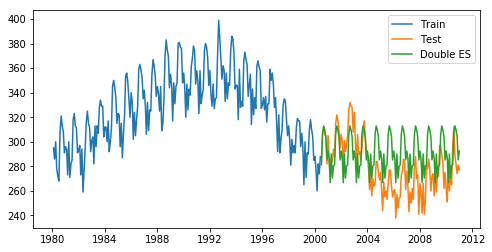

In [21]:
# no trend, just seasonality (multiplicative), no damping
# forecast will be 'squiggly' line with no upwards or downwards trend
from statsmodels.tsa.api import ExponentialSmoothing

y_hat_avg = test_df.copy()
fit1 = ExponentialSmoothing(np.asarray(train_df['num_births']), seasonal_periods=12, trend=None, seasonal='multiplicative',).fit(smoothing_level=0.19, smoothing_seasonal=0.1)
y_hat_avg['DES'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['DES'], label='Double ES')
plt.legend(loc='best')
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.DES))
print(rms)

22.396315125410176


## 5.2.e. Holt-Winters (level + trend + season)

Parameters:	
* endog (array-like) – Time series
* trend ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of trend component.
* damped (bool, optional) – Should the trend component be damped.
* seasonal ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of seasonal component.
* seasonal_periods (int, optional) – The number of seasons to consider for the holt winters.

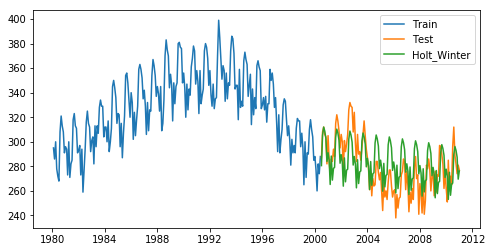

In [7]:
# here we have trend and seasonality, so we will use Holt-Winters
# the squiggly line should go up or down, depending the trend
from statsmodels.tsa.api import ExponentialSmoothing

y_hat_avg = test_df.copy()
fit1 = ExponentialSmoothing(np.asarray(train_df['num_births']),\
                            seasonal_periods=12, trend='mul', \
                            seasonal='mul').fit(smoothing_level=0.19, smoothing_slope=0.005,smoothing_seasonal=0.1)
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt_Winter))
print(rms)

17.295146162092756


## 5.2.e. Gridsearching Holt-Winters (level + trend + season)

I urge you to walk through all of the steps in this outstanding blog post by Machine Learning Mastery and take time to process the code: https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/ 

That being said, here's the final code for finding the ideal Holt-Winter params for the US birth data above:

In [2]:
# grid search ets models for US monthly birth data
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pandas import read_table
from pandas import datetime

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul'] # removed none
	d_params = [True, False] # damped
	s_params = ['add', 'mul'] # removed none
	p_params = seasonal
	b_params = [False] # Box Cox
	r_params = [False] # remove bias
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
    df = pd.read_table('data/birth.txt')
    series = df.set_index(pd.DatetimeIndex(start='1/1/1980', end='12/31/2010', freq='M'))
    data = series.values
    print(data.shape)
    # data split: here we used 127 observations
    n_test = 127
    # model configs
    cfg_list = exp_smoothing_configs(seasonal=[6,12])
    # grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

(372, 1)
 > Model[['add', False, 'add', 12, False, False]] 11.021
 > Model[['add', False, 'add', 6, False, False]] 14.222
 > Model[['add', True, 'add', 6, False, False]] 14.196
 > Model[['add', True, 'add', 12, False, False]] 10.999
done
['add', True, 'add', 12, False, False] 10.999381262890353
['add', False, 'add', 12, False, False] 11.021152740925336
['add', True, 'add', 6, False, False] 14.196014807257932


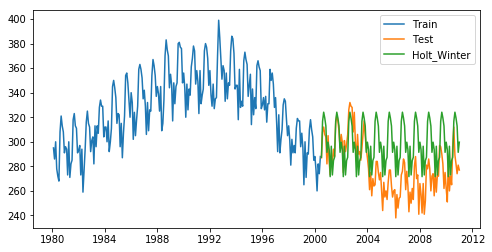

In [9]:
# using optimized=True and hyperparams from modified gridsearch above
from statsmodels.tsa.api import ExponentialSmoothing

y_hat_avg = test_df.copy()
fit1 = ExponentialSmoothing(np.asarray(train_df['num_births']),seasonal_periods=12, trend='add', damped=True, seasonal='add').fit(optimized=True)
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt_Winter))
print(rms)

27.248778519921416
